In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
df = pd.read_csv("timeline.csv")
df.head()

,Date,New
0,1/1/2020,0
1,1/2/2020,0
2,1/3/2020,0
3,1/4/2020,0
4,1/5/2020,0


In [3]:
df.shape

(489, 2)

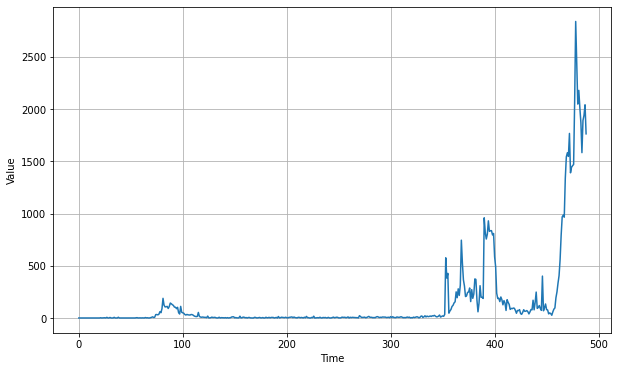

In [4]:
time = np.arange(489, dtype="float32")
series = df['New'].values.astype("float32")
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

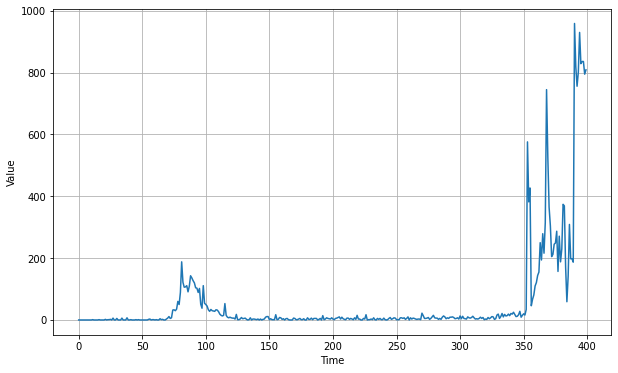

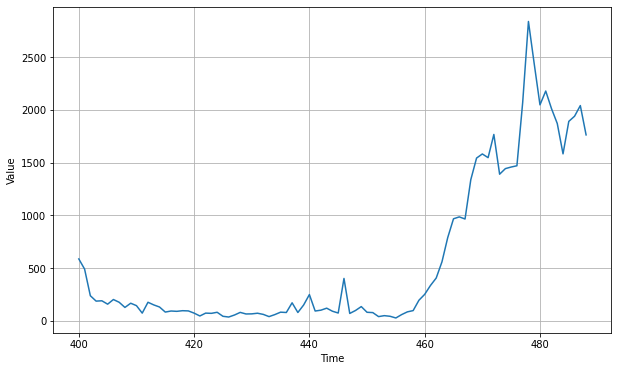

In [5]:
split_time = 400
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Moving Average

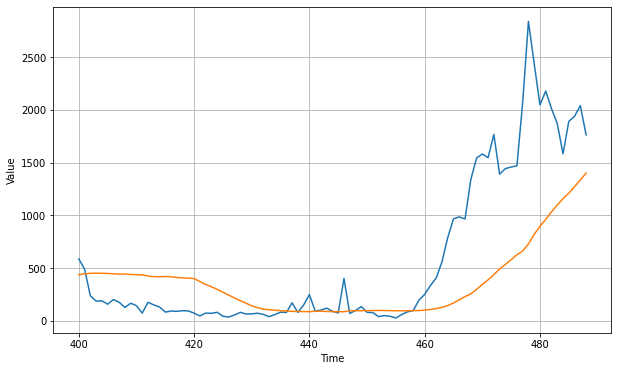

In [6]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [7]:
print(mean_squared_error(x_valid, moving_avg))
print(mean_absolute_error(x_valid, moving_avg))

342444.03
391.49472


# RNN

In [456]:
window_size = 30
batch_size = 5
shuffle_buffer_size = 1000

In [457]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
train_set 

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>

In [458]:
a = 73
tf.keras.backend.clear_session()
tf.random.set_seed(a)
np.random.seed(a)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(30, return_sequences=True, activation = "relu"),
  tf.keras.layers.SimpleRNN(30, activation = "relu"),
  tf.keras.layers.Dense(1, activation = "relu")
])
model.compile(loss="mse",
              optimizer="Adamax",
              metrics=["mae"])
history = model.fit(train_set, epochs=200)

Epoch 1/200
74/74 [==============================] - 2s 7ms/step - loss: 26449.9023 - mae: 57.6137
Epoch 2/200
74/74 [==============================] - 1s 7ms/step - loss: 20248.6348 - mae: 50.6480
Epoch 3/200
74/74 [==============================] - 1s 7ms/step - loss: 14850.1543 - mae: 42.7280
Epoch 4/200
74/74 [==============================] - 1s 7ms/step - loss: 10463.6943 - mae: 34.3868
Epoch 5/200
74/74 [==============================] - 1s 7ms/step - loss: 7236.6836 - mae: 27.3050
Epoch 6/200
74/74 [==============================] - 1s 6ms/step - loss: 6090.6860 - mae: 23.5242
Epoch 7/200
74/74 [==============================] - 1s 7ms/step - loss: 5665.8804 - mae: 22.6039
Epoch 8/200
74/74 [==============================] - 1s 7ms/step - loss: 5458.9478 - mae: 22.1193
Epoch 9/200
74/74 [==============================] - 1s 6ms/step - loss: 5267.2998 - mae: 21.9221
Epoch 10/200
74/74 [==============================] - 1s 7ms/step - loss: 5063.1211 - mae: 21.6351
Epoch 11/200
74

74/74 [==============================] - 1s 7ms/step - loss: 854.6831 - mae: 9.0503
Epoch 166/200
74/74 [==============================] - 1s 7ms/step - loss: 882.0858 - mae: 9.4180
Epoch 167/200
74/74 [==============================] - 1s 7ms/step - loss: 884.3997 - mae: 9.7196
Epoch 168/200
74/74 [==============================] - 1s 7ms/step - loss: 867.0590 - mae: 9.1352
Epoch 169/200
74/74 [==============================] - 1s 7ms/step - loss: 846.7416 - mae: 9.0149
Epoch 170/200
74/74 [==============================] - 1s 7ms/step - loss: 859.2839 - mae: 9.1267
Epoch 171/200
74/74 [==============================] - 1s 6ms/step - loss: 879.5952 - mae: 9.4850
Epoch 172/200
74/74 [==============================] - 1s 7ms/step - loss: 908.0341 - mae: 9.9942
Epoch 173/200
74/74 [==============================] - 1s 7ms/step - loss: 848.6633 - mae: 9.1221
Epoch 174/200
74/74 [==============================] - 1s 7ms/step - loss: 841.2557 - mae: 8.7956
Epoch 175/200
74/74 [=============

In [459]:
forecast=[]
for i in range(len(series) -  window_size): # 0-458
    forecast.append( model.predict(series[i:i + window_size][np.newaxis])) # 0-30 1-31 ... 458-488
forecast = forecast[split_time-window_size:]# 488  370-488
results = np.array(forecast)[:,0,0]

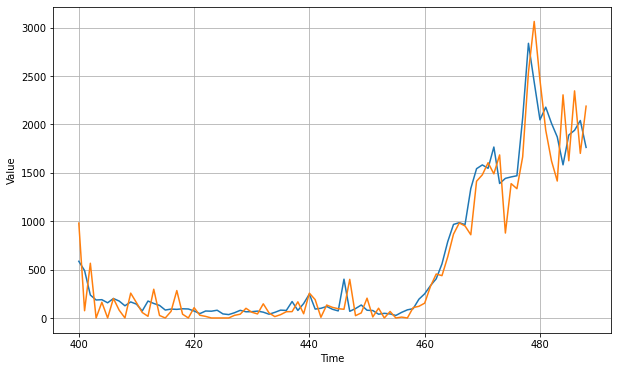

In [460]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [461]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

46071.844

# LSTM

In [21]:
window_size = 20
batch_size = 5
shuffle_buffer_size = 1000

In [22]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [23]:
a=88
tf.keras.backend.clear_session()
tf.random.set_seed(a)
np.random.seed(a)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
 tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer="Adamax",
              metrics=["mae"])
history = model.fit(dataset, epochs=200)

Epoch 1/200
76/76 [==============================] - 9s 13ms/step - loss: 44.4218 - mae: 44.9022
Epoch 2/200
76/76 [==============================] - 1s 17ms/step - loss: 36.6292 - mae: 37.1032
Epoch 3/200
76/76 [==============================] - 1s 14ms/step - loss: 33.0282 - mae: 33.4983
Epoch 4/200
76/76 [==============================] - 1s 13ms/step - loss: 31.0918 - mae: 31.5618
Epoch 5/200
76/76 [==============================] - 1s 13ms/step - loss: 30.4041 - mae: 30.8771
Epoch 6/200
76/76 [==============================] - 1s 14ms/step - loss: 29.7537 - mae: 30.2287
Epoch 7/200
76/76 [==============================] - 1s 16ms/step - loss: 30.0737 - mae: 30.5521
Epoch 8/200
76/76 [==============================] - 1s 18ms/step - loss: 29.7791 - mae: 30.2596
Epoch 9/200
76/76 [==============================] - 1s 16ms/step - loss: 29.9419 - mae: 30.4178
Epoch 10/200
76/76 [==============================] - 1s 15ms/step - loss: 29.3982 - mae: 29.8751
Epoch 11/200
76/76 [=========

76/76 [==============================] - 1s 12ms/step - loss: 14.5021 - mae: 14.9681
Epoch 85/200
76/76 [==============================] - 1s 16ms/step - loss: 14.4005 - mae: 14.8599
Epoch 86/200
76/76 [==============================] - 1s 17ms/step - loss: 14.4399 - mae: 14.9038
Epoch 87/200
76/76 [==============================] - 1s 13ms/step - loss: 14.1026 - mae: 14.5752
Epoch 88/200
76/76 [==============================] - 1s 13ms/step - loss: 14.8444 - mae: 15.3100
Epoch 89/200
76/76 [==============================] - 1s 13ms/step - loss: 15.7463 - mae: 16.2059
Epoch 90/200
76/76 [==============================] - 1s 12ms/step - loss: 14.7806 - mae: 15.2484
Epoch 91/200
76/76 [==============================] - 1s 14ms/step - loss: 13.4898 - mae: 13.9538
Epoch 92/200
76/76 [==============================] - 1s 13ms/step - loss: 14.1044 - mae: 14.5683
Epoch 93/200
76/76 [==============================] - 1s 12ms/step - loss: 14.9237 - mae: 15.3889
Epoch 94/200
76/76 [=============

76/76 [==============================] - 1s 11ms/step - loss: 12.6757 - mae: 13.1439
Epoch 168/200
76/76 [==============================] - 1s 11ms/step - loss: 12.8163 - mae: 13.2836
Epoch 169/200
76/76 [==============================] - 1s 11ms/step - loss: 11.9051 - mae: 12.3526
Epoch 170/200
76/76 [==============================] - 1s 13ms/step - loss: 13.0770 - mae: 13.5327
Epoch 171/200
76/76 [==============================] - 1s 14ms/step - loss: 12.3555 - mae: 12.8170
Epoch 172/200
76/76 [==============================] - 1s 13ms/step - loss: 12.0652 - mae: 12.5278
Epoch 173/200
76/76 [==============================] - 1s 15ms/step - loss: 12.6444 - mae: 13.1073
Epoch 174/200
76/76 [==============================] - 1s 11ms/step - loss: 11.8867 - mae: 12.3401
Epoch 175/200
76/76 [==============================] - 1s 11ms/step - loss: 13.3411 - mae: 13.7981
Epoch 176/200
76/76 [==============================] - 1s 11ms/step - loss: 14.7210 - mae: 15.1828
Epoch 177/200
76/76 [===

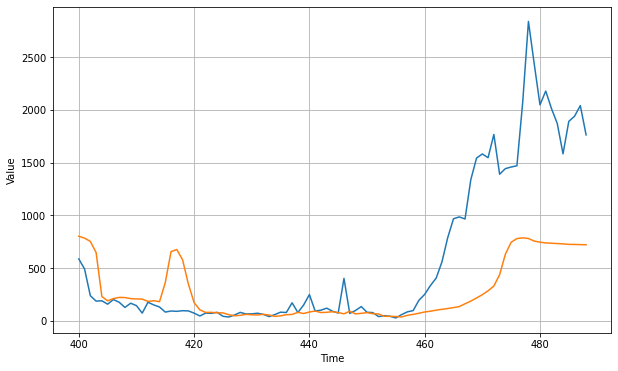

In [24]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [25]:
tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

423794.7

# สรุป

- การใช้ RNN ได้โมเดลที่มีการทำนายแม่นยำกว่า LSTM ในกรณีที่ตั้งพารามิเตอร์คล้ายกันเพราะ
-
-


